In [46]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [47]:
data = pd.read_csv('casts.csv')
data.head()

,fid,username,reaction_count,reply_count,reaction_reply_ratio,url,text
0,236812,"<a href=""https://warpcast.com/phaverapp"" targe...",6024,232,25.965517,"<a href=""https://warpcast.com/phaverapp/0xaacc...","Even markets go down, you will stay $SOCIAL 🚀 ..."
1,236812,"<a href=""https://warpcast.com/phaverapp"" targe...",5348,182,29.384615,"<a href=""https://warpcast.com/phaverapp/0x513e...",GM Frens! 💜 It's time to update Phaver from Ap...
2,345284,"<a href=""https://warpcast.com/cryptoteluguo"" t...",5113,82,62.353659,"<a href=""https://warpcast.com/cryptoteluguo/0x...",💥Simple guide on _xyz_ Node whitelist\n\n✅Bina...
3,535436,"<a href=""https://warpcast.com/cryptohindio"" ta...",4996,127,39.338583,"<a href=""https://warpcast.com/cryptohindio/0x7...",😁Will waiting for $SOCIAL TGE
4,535436,"<a href=""https://warpcast.com/cryptohindio"" ta...",4928,101,48.792079,"<a href=""https://warpcast.com/cryptohindio/0xc...",🔴Red morning


In [48]:
# Converting all usernames to strings, then remove URLs
data['username'] = data['username'].astype(str).apply(lambda x: re.sub(r"http\S+", "", x))

In [49]:
# Data Cleaning and Preprocessing
stop_words = set(stopwords.words('english'))
data['cleaned_text'] = data['text'].apply(lambda x: ' '.join(
    [word.lower() for word in word_tokenize(re.sub(r'[^\w\s]', '', str(x))) if word.lower() not in stop_words]))


#### Topic Modeling using LDA

In [50]:

def lda_topic_modeling(text_data, num_topics=5):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(text_data)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(dtm)
    return lda, vectorizer

In [51]:
lda_model, lda_vectorizer = lda_topic_modeling(data['cleaned_text'])
lda_topics = lda_model.components_

In [52]:
# Display LDA topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

display_topics(lda_model, lda_vectorizer.get_feature_names_out(), 10)

Topic #1:
check tip stats promotion useful nframe nif wildcard supportðÿ im
Topic #2:
masks phaver nan social new time summer nft live work
Topic #3:
mint free không untitled1230 nnhttpsfarquestcontractsdegenuntitled12304 có người những sáng mọi
Topic #4:
gm good day today morning frens social like summer want
Topic #5:
và cảm đã viết bài của này ơn một rất


#### Inferences: 

1. Technical Focus: Topic 1 suggests a focus on product features, user support, or technical discussions.
2. Social Engagement: Topic 2 indicates a potential interest in social trends and current events.
3. Language Barrier: Topics 3 and 5 suggest the presence of a language barrier that might require translation or filtering.
4. Community Building: Topic 4 points to a focus on community building and engagement.

##### Word Embedding using Word2Vec

In [53]:
tokenized_text = data['cleaned_text'].apply(word_tokenize)
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4)
word_vectors = w2v_model.wv

/Users/lalithaprasuna/opt/anaconda3/envs/DL/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 5616 (\N{CANADIAN SYLLABICS CARRIER GO}) missing from current font.
  fig.canvas.draw()
/Users/lalithaprasuna/opt/anaconda3/envs/DL/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 5511 (\N{CANADIAN SYLLABICS TLHI}) missing from current font.
  fig.canvas.draw()
/Users/lalithaprasuna/opt/anaconda3/envs/DL/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 53080 (\N{HANGUL SYLLABLE KON}) missing from current font.
  fig.canvas.draw()
/Users/lalithaprasuna/opt/anaconda3/envs/DL/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 53584 (\N{HANGUL SYLLABLE TEN}) missing from current font.
  fig.canvas.draw()
/Users/lalithaprasuna/opt/anaconda3/envs/DL/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 52768 (\N{HANGUL SYLLABLE CEU}) missing from current font.
  fig.canvas.draw()
/Users/lalithaprasuna/opt/an

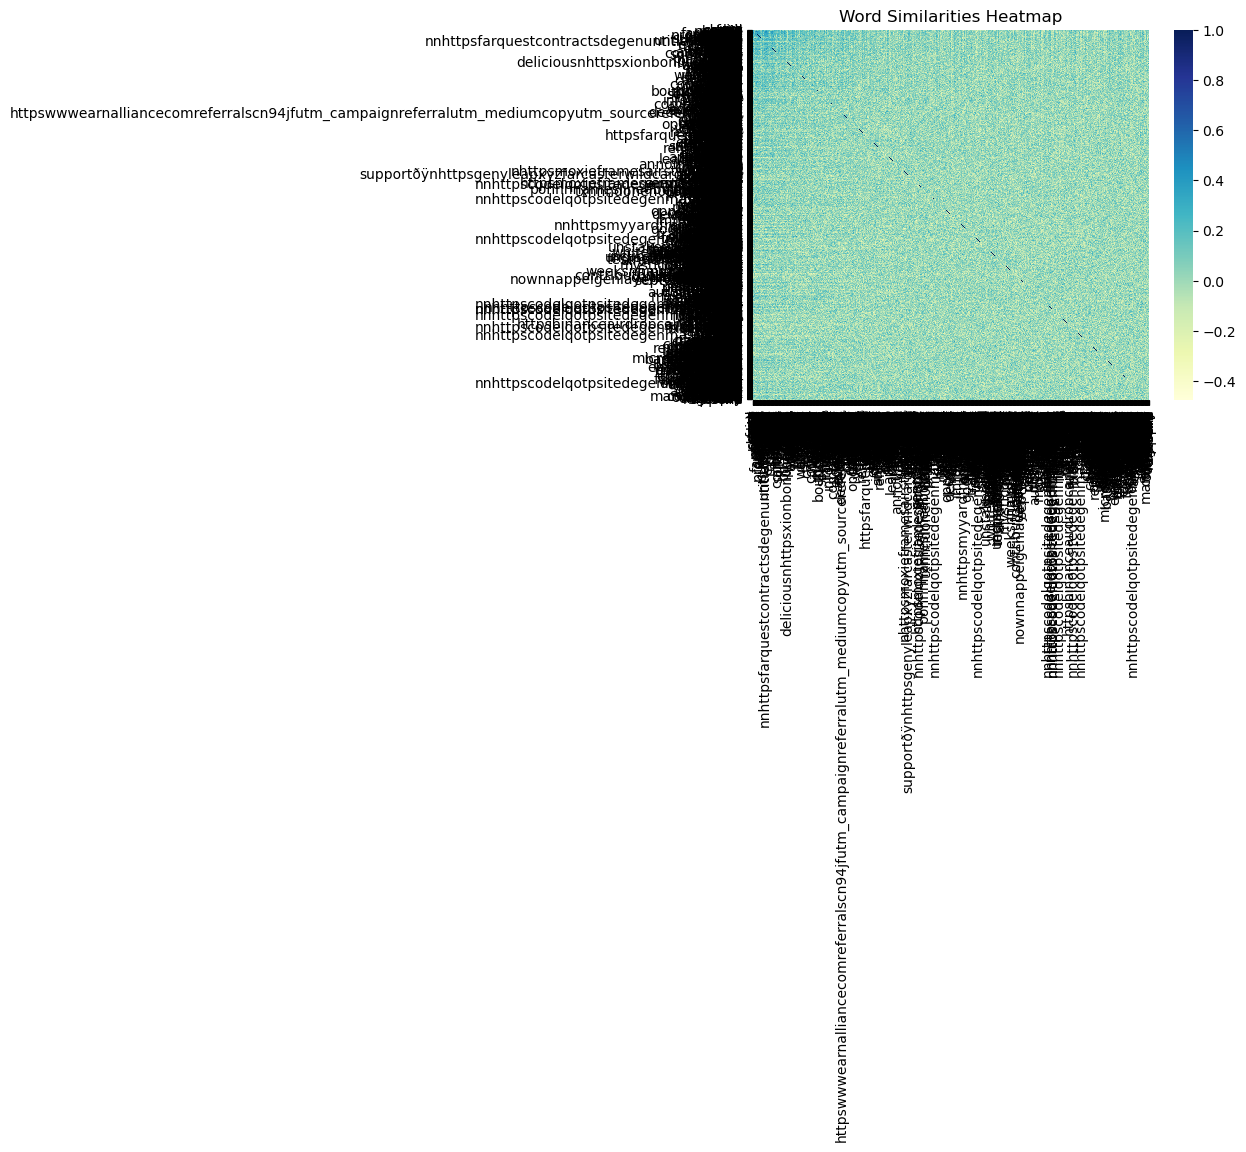

In [54]:
# Similarity heatmap
words = list(word_vectors.index_to_key)
word_similarities = cosine_similarity([word_vectors[w] for w in words])
sns.heatmap(word_similarities, xticklabels=words, yticklabels=words, cmap="YlGnBu")
plt.title('Word Similarities Heatmap')
plt.show()

#### TF-IDF

In [55]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])

In [56]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
data['sentiment'] = data['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [57]:
# Calculate Relevance (Assuming relevance is proportional to reactions and replies)
data['relevance'] = data['reaction_count'] + data['reply_count']


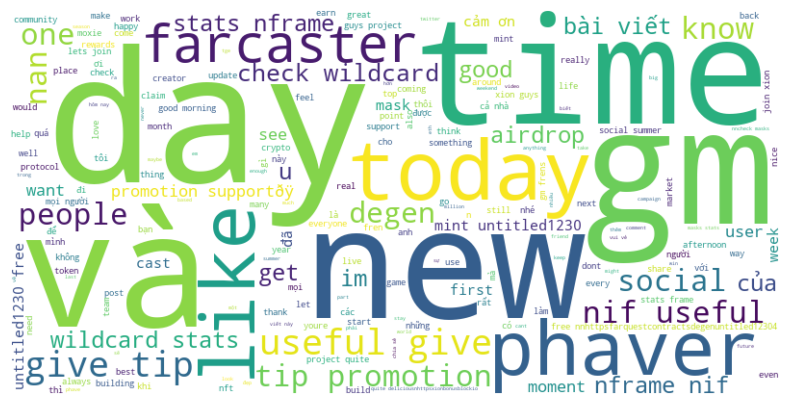

In [58]:
#Visualizing Word Clouds for trending words
wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(' '.join(data['cleaned_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

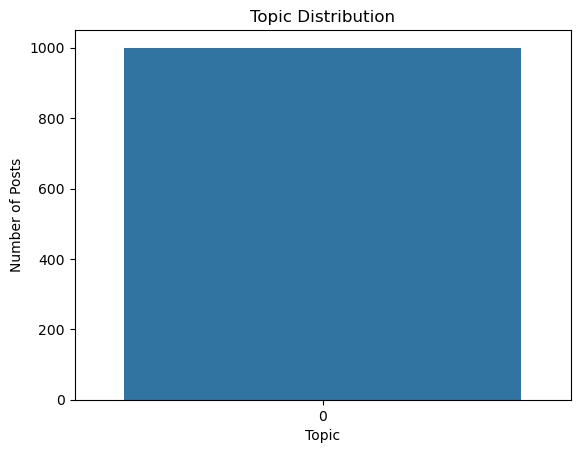

In [59]:
# Topic Distribution
topic_distribution = np.argmax(lda_model.transform(lda_vectorizer.transform(data['cleaned_text'])), axis=1)
sns.countplot(topic_distribution)
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Number of Posts')
plt.show()

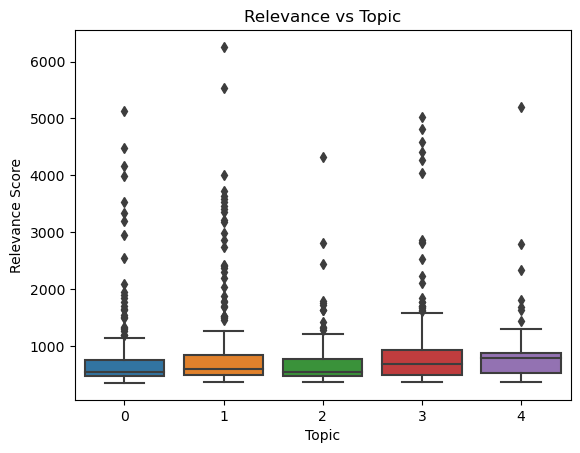

In [60]:
# Relevance vs Topic Visualization
data['topic'] = topic_distribution
sns.boxplot(x='topic', y='relevance', data=data)
plt.title('Relevance vs Topic')
plt.xlabel('Topic')
plt.ylabel('Relevance Score')
plt.show()


In [61]:
# Word Associations using Word2Vec
word = 'ethereum'  
similar_words = w2v_model.wv.most_similar(word, topn=10)
print(f"Words most similar to {word}:")
print(similar_words)

Words most similar to ethereum:
[('obvious', 0.35660484433174133), ('diamonds', 0.3024044334888458), ('góc', 0.2989591956138611), ('penguins', 0.29737213253974915), ('rain', 0.29132720828056335), ('bị', 0.28899046778678894), ('message', 0.28881072998046875), ('creative', 0.28874471783638), ('shots', 0.2836814224720001), ('fall', 0.2777744233608246)]


#### Word Association Analysis:

Ethereum Context: The words associated with "ethereum" (diamonds, penguins, rain) suggest a diverse range of topics related to the cryptocurrency.